# Classifying Lyrics into genres: A study of the Million Song Dataset

#### This notebook goes through the steps of clustering a 1% subset to try and predict the genre tags that are pre-existing that were generated by the University of Vienna
#### The data is not included in this notebook and must be downloaded to run this code. Go to the [Million Song Dataset Homepage](https://labrosa.ee.columbia.edu/millionsong/) to learn more about how to aquire the data (the subset as well as the complete one million song database(s))

### **Imports**

In [78]:
import pandas as pd
from multiprocessing.pool import Pool
import numpy as np
import os; import sys; 
import IPython
from numba import jit

#Modeling
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel
from sklearn.preprocessing import LabelEncoder; from sklearn.linear_model import LogisticRegression; from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier; from sklearn.model_selection import GridSearchCV, train_test_split; from sklearn.metrics import accuracy_score;

#Databases
import sqlite3; import sqlalchemy
import tables

#Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#This function was supplied by the Million Song Dataset to get data from the hdf5 files
import hdf5_getters as GETTERS

#Comment out if you wish to see all warnings
import warnings
warnings.filterwarnings('ignore')

### **Reading in the tracks data from the mounted partition**

In [79]:
songs = pd.read_csv('./MillionSongSubset/AdditionalFiles/subset_unique_tracks.txt', sep = '<SEP>', names = ['ID','SONG ID','ARTIST NAME','SONG TITLE'])

songs = songs.sort_values(by = 'ID')

cols = list(songs.columns)
cols[0] = 'track_id'
songs.columns = cols

In [80]:
#Combining the title and artist for a more representative index whe I set up the vectorized dataframe
songs['TITLE_AND_ARTIST'] = songs['SONG TITLE'] + ' - ' + songs['ARTIST NAME']

### Pulling in the lyrics data

In [81]:
#parsing the sql database for the lyrics data
con = sqlite3.connect('mxm_dataset.db')
words = pd.read_sql(sql = 'SELECT * FROM words', con = con)
lyrics_0 = pd.read_sql(sql = 'SELECT * FROM lyrics', con = con)
con.close()

#Merging in the aforementioned column for the index of the vectorized dataframe
lyrics_1 = pd.merge(songs[['track_id','TITLE_AND_ARTIST']],lyrics_0, how = 'inner')

#Getting rid of columns I don't need
lyrics = lyrics_1[['TITLE_AND_ARTIST','word','count']]

#Converting the melted dataframe into a pivot table that will serve as my vectorized dataset
lyrics = pd.pivot_table(lyrics[['TITLE_AND_ARTIST','word','count']], values = 'count', index = 'TITLE_AND_ARTIST', columns = ['word'])

In [82]:
#Filling in 0s
lyrics = lyrics.replace(to_replace=np.NaN, value = 0)

lyrics

word,&,000,1,10,100,12,13,15,16,2,...,è,é,él,és,était,être,ô,über,–,‘caus
TITLE_AND_ARTIST,,,,,,,,,,,,,,,,,,,,,
(Bloody Paw On The) Kill Floor - Busdriver,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
(I Used To Couldn't Dance) Tight Pants - Eagles Of Death Metal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
(I'm So) Afraid Of Losing You Again - Charley Pride,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
(This Is Not A) Love Song (Live) - Public Image Ltd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
(We Don't Need This) Fascist Groove Thang - Heaven 17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...and Heavens Cried Blood - Swallow The Sun,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100 Ways ( LP Version ) - Porno For Pyros,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000 Good Intentions - Rise Against,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10000 Km - La Portuaria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [83]:
#Dropping stop words and very short words from features
label = list(ENGLISH_STOP_WORDS)
others = [i for i in lyrics.columns if len(i)<=2]
label.extend(others)

for l in label:    
    try:
        lyrics.drop(l, inplace=True)
    except:
        pass

In [84]:
#Replacing the tokens with unstemmed versions for better comprehension
unstem = pd.read_csv('./mxm_reverse_mapping.txt', sep = '<SEP>', names = ['original','unstemmed'])

In [85]:
unstem.set_index('original', inplace=True)

In [86]:
#removing the difference from the unstemmed set between the existing tokens and the unstemmed versions
cols = set(lyrics.columns)
unstemd = set(unstem.index)

sub = list(unstemd.difference(cols))

unstem = unstem.drop(sub)

lyrics.columns = unstem['unstemmed']

### LDA

> *LDA is the Latent Dirichlet allocation unsupervised method for **[Topic Modeling](https://en.wikipedia.org/wiki/Topic_model)** vectorized documents in a corpus into classes*


> *LDA takes the tokenized data and:*
 - Assigns each word to a topic randomly. This is the first iteration of the clustering algorithm.
 - Then, based on the probability of the topic given a certain document and the probability of the topic given a certain word, the algorithm recalculates the assignments. 
 - The algorithm essentially calculates the probability that a certain topic generated a certain word.
 - This process loops until convergence of probability, resulting in topics with most related words clustered together within them.

In [87]:
#Setting up the format to use the gensim modeling library
lyrics_text = [lyrics.columns[lyrics.loc[index,:].nonzero()] for index in lyrics.index]
dictionary = corpora.Dictionary(lyrics_text)
corpus_plot = [dictionary.doc2bow(text) for text in lyrics_text]

In [88]:
lyrics_text

[Index(['aus', 'tai', 'christ', 'oscuridad', 'fui', 'united', 'nine', 'muss',
        'must', 'worte',
        ...
        'swear', 'tight', 'wollte', 'brand', 'continue', 'llevo', 'flip',
        'c'mon', 'junk', 'monday'],
       dtype='object', name='unstemmed', length=188),
 Index(['aus', 'hide', 'fui', 'nine', 'want', 'thee', 'endlich', 'consolation',
        'bust', 'cambiar', 'boss', 'much', 'entonces', 'possess', 'letra',
        'conviction', 'rot', 'torch', 'bli', 'destroy', 'champagne', 'olhos',
        'shoes', 'crystal', 'bowl', 'driven', 'death', 'shelf', 'hallelujah',
        'mary', 'stupid', 'sacred', 'ciudad', 'ayer', 'don’t', 'fairy', 'sober',
        'cloudy', 'donde', 'storm', 'parce', 'steht', 'tuve', '(3x)', 'famous',
        'geld', 'dois', 'garden', 'stomp', 'porch', 'siehst', 'chosen',
        'temple', 'become', 'denk', 'tired', 'winner', 'should', 'envy',
        'familiar', 'view', 'dalla', 'spare', 'satisfied', 'motivo', 'zwei',
        'esa', 'l'eau', 'mä

In [89]:
#Function to run an LDA and do a coherance model on it to find the best value of number of topics
def coherence_search(dictionary, corpus_dict, text, upper_limit, start, step):
    from gensim.models.coherencemodel import CoherenceModel
    coherence_score = []
    model_list = []
    for num_topics in range(start, upper_limit, step):
        fun_model=models.ldamulticore.LdaMulticore(corpus=corpus_dict, 
                           id2word=dictionary, 
                           num_topics=num_topics,
                           passes = 5,
                           minimum_probability = 0.01)
        model_list.append(fun_model)
        coherencem = CoherenceModel(model=fun_model, texts=text, dictionary=dictionary, coherence='c_v', processes = 15)
        coherence_score.append(coherencem.get_coherence())

    return model_list, coherence_score

**Running the function and getting our LDA**

In [90]:
#Runnin function above for lyrics set
%timeit
search = coherence_search(dictionary=dictionary,corpus_dict=corpus_plot,text = lyrics_text, upper_limit= 100, start = 5, step = 5)

### Plotting Coherance to find best number of topics to cluster over

In [91]:
model_result = search[0]
scores = search[1]

model_5 = model_result[0]
model_10 = model_result[1]
model_15 = model_result[2]
model_20 = model_result[3]
model_25 = model_result[4]
model_30 = model_result[5]
model_35 = model_result[6]
model_40 = model_result[7]
model_45 = model_result[8]
model_50= model_result[9]
model_55 = model_result[10]
model_60 = model_result[11]
model_65 = model_result[12]
model_70 = model_result[13]
model_75 = model_result[14]
model_80 = model_result[15]
model_85 = model_result[16]
model_90 = model_result[17]
model_95 = model_result[18]

<Figure size 864x720 with 0 Axes>

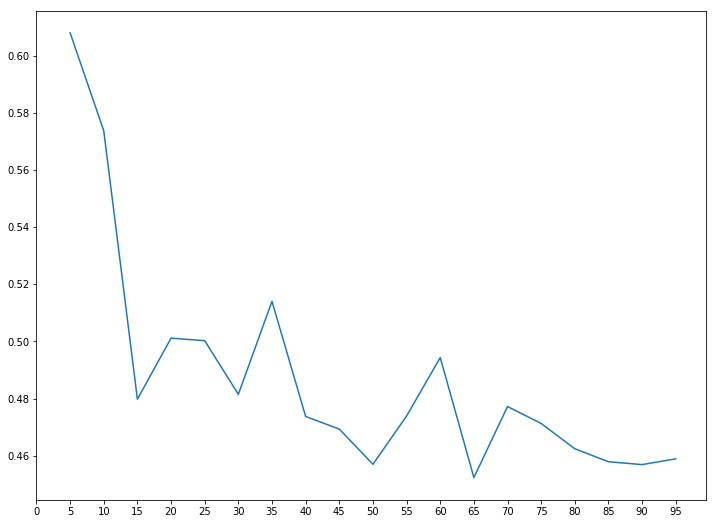

In [92]:
fig = plt.figure(figsize=(12, 10));
plt.figure(figsize=(12,9));
plt.plot(range(5,100,5),scores);
plt.xticks(np.arange(0,100, step =5),list(range(0,100,5)));
plt.savefig('model_plot.png', bbox_inches='tight');
IPython.display.Image(filename='./model_plot.png');

![title](./model_plot.png)

   *As you can see from the plot above the best model was one that used **10 topics**  and the more topics that were added the trend shows a negative correlation with signal from topics.*

<br>
   
   *I didn't want to go too low, as this may cause the groupings to be trivial (similar to how having only 2 topics would have a lot of signal but not much meaning realistically because it would group things that were different together based on even the slightest similarity.*

In [93]:
#A singular model initializer if the wait for the coherence model above is inconvenient
final_model=models.ldamulticore.LdaMulticore(corpus=corpus_plot, 
                           id2word=dictionary, 
                           num_topics=10,
                           passes = 5,
                           minimum_probability = 0.01)

In [94]:
#Creating a matrix of the different topics and the probabilities for top 100 tokens
topic_matrix = pd.DataFrame(final_model.get_topics())

topic_matrix

words = list(lyrics.columns)

topic_words = [[words[i[0]] for i in final_model.get_topic_terms(j, topn = 100)] for j in range(final_model.num_topics)]

In [95]:
df_topics = pd.DataFrame(topic_words).T
df_topics.columns= [i for i in range(1,11)]
df_topics.index = range(1,101)
df_topics.to_csv('./csv_subset/topics.csv')
df_topics

,1,2,3,4,5,6,7,8,9,10
1,sleeve,dwell,four,total,lonesome,lonesome,sleeve,total,tool,sleeve
2,total,tool,sleeve,lonesome,callin',horn,four,med,jumpin',daughter
3,georgia,sleeve,total,med,med,callin',voit,lonesome,ven,must
4,lonesome,smack,lonesome,nine,voit,sleeve,callin',voit,opposite,qu'on
5,four,digas,bank,sleeve,georgia,illuminate,lonesome,illuminate,och,total
6,med,georgia,med,four,four,daughter,ton,sleeve,ton,callin'
7,cradle,thirsty,whose,callin',sleeve,solamente,georgia,cradle,dog,smack
8,callin',ton,callin',voit,wreck,total,total,horn,join,illuminate
9,voit,western,voit,horn,horn,voit,med,solamente,sleeve,toll
10,fui,dom,sorry,toll,fui,georgia,fui,callin',nasty,cradle


### Wordclouds of different topics
#### Code for below wordcloud taken from [here](https://github.com/amueller/word_cloud/blob/master/examples/masked.py)

(-0.5, 1992.5, 2192.5, -0.5)

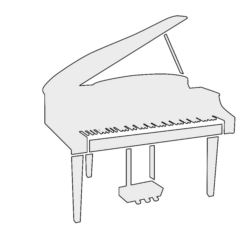

In [125]:
from os import path
from PIL import Image

from wordcloud import WordCloud, STOPWORDS

# Read the whole text.
t = list(lyrics_0['word'])
text_cloud = ' '.join(t)

# read the mask image
music_mask = np.array(Image.open("music.png"))

stopwords = label.extend(list(STOPWORDS))

wc = WordCloud(background_color="white", max_words=2000, mask=music_mask,
               stopwords=stopwords, contour_width=3, contour_color='steelblue')

# generate word cloud
wc.generate(text_cloud)

# store to file
wc.to_file('./wordclouds/words.png')

# show
plt.imshow(wc, interpolation='bilinear');
plt.axis("off")
#plt.figure()
plt.imshow(music_mask, cmap=plt.cm.gist_rainbow, interpolation='bilinear');
plt.axis("off")


![title](./wordclouds/words.png)

### Assigning Topics to Songs

> *Utlizing* ***[Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity)*** *which utilizes the definition of similairy through the relationship between the dot product of 2 vectors and cosine:*
![cosine sim formula](https://wikimedia.org/api/rest_v1/media/math/render/svg/1d94e5903f7936d3c131e040ef2c51b473dd071d)

In [97]:
#Calculates the cosine similarity between 2 lists of strings
def cosine_sim(a,b):
    from collections import Counter

    # count word occurrences
    a_vals = Counter(a)
    b_vals = Counter(b)

    # convert to word-vectors
    words  = list(a_vals.keys() | b_vals.keys())
    a_vect = [a_vals.get(word, 0) for word in words]        
    b_vect = [b_vals.get(word, 0) for word in words]        

    # find cosine
    len_a  = sum(av*av for av in a_vect) ** 0.5             
    len_b  = sum(bv*bv for bv in b_vect) ** 0.5             
    dot_product = sum(av*bv for av,bv in zip(a_vect, b_vect))    
    cosine_similarity = dot_product / (len_a * len_b)                          
    
    return cosine_similarity

In [98]:
#demo of the function
cosine_sim(['This', 'is', 'a', 'test', 'list', 'with', 'extra', 'words'],['This', 'is', 'a', 'test', 'list'])

0.7905694150420948

In [99]:
#dropping because the values are all 0 in score_matrix, causing issues
try:
    lyrics.drop(labels = ['Vincent - Madilu System'], axis = 0, inplace=True)
except:
    pass

In [100]:
df_id = lyrics_1[['track_id','TITLE_AND_ARTIST']]
df_id.drop_duplicates(inplace=True)

df_id

,track_id,TITLE_AND_ARTIST
0,TRAAABD128F429CF47,Soul Deep - The Box Tops
74,TRAAAEF128F4273421,Something Girls - Adam Ant
133,TRAAAFD128F92F423A,Face the Ashes - Gob
215,TRAAARJ128F9320760,Pink World - Planet P Project
306,TRAABJV128F1460C49,Tonight Will Be Alright - Lionel Richie
392,TRAABLR128F423B7E3,Floating - Blue Rodeo
494,TRAABVM128F92CA9DC,Caught In A Dream - Tesla
613,TRAACER128F4290F96,Setting Fire to Sleeping Giants - The Dillinge...
735,TRAACFV128F935E50B,James (Hold The Ladder Steady) - SUE THOMPSON
811,TRAACHN128F1489601,Made Like This (Live) - Five Bolt Main


In [101]:
df_id.drop(df_id.loc[df_id['TITLE_AND_ARTIST'] == 'Vincent - Madilu System'].index, axis = 0, inplace=True)

In [102]:
score_matrix = []
for name in lyrics.index:
    scores = []
    word_index = np.nonzero(lyrics.loc[name])
    word_list = tuple([lyrics.columns[i] for i in word_index][0])
    for topic in topic_words:
        try:
            score = cosine_sim(list(word_list),topic)
            scores.append(score)
        except:
            pass
    score_matrix.append(scores)
        

df_cos = pd.DataFrame(score_matrix, columns=['Topic 1','Topic 2','Topic 3','Topic 4','Topic 5','Topic 6','Topic 7','Topic 8','Topic 9','Topic 10'], index=lyrics.index)
df_cos.to_csv('./csv_subset/cluster_probs.csv')
df_cos

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10
TITLE_AND_ARTIST,,,,,,,,,,
(Bloody Paw On The) Kill Floor - Busdriver,0.036466,0.000000,0.043759,0.036466,0.043759,0.036466,0.036466,0.051053,0.051053,0.043759
(I Used To Couldn't Dance) Tight Pants - Eagles Of Death Metal,0.023570,0.000000,0.047140,0.023570,0.035355,0.023570,0.023570,0.035355,0.011785,0.023570
(I'm So) Afraid Of Losing You Again - Charley Pride,0.051640,0.000000,0.038730,0.038730,0.038730,0.051640,0.038730,0.051640,0.012910,0.038730
(This Is Not A) Love Song (Live) - Public Image Ltd,0.065094,0.026038,0.052076,0.052076,0.065094,0.052076,0.065094,0.078113,0.039057,0.039057
(We Don't Need This) Fascist Groove Thang - Heaven 17,0.049507,0.019803,0.049507,0.039606,0.049507,0.039606,0.019803,0.059409,0.019803,0.039606
...and Heavens Cried Blood - Swallow The Sun,0.047140,0.011785,0.035355,0.047140,0.023570,0.047140,0.035355,0.058926,0.011785,0.058926
100 Ways ( LP Version ) - Porno For Pyros,0.043644,0.010911,0.010911,0.021822,0.043644,0.032733,0.021822,0.054554,0.010911,0.021822
1000 Good Intentions - Rise Against,0.039223,0.009806,0.029417,0.029417,0.039223,0.039223,0.039223,0.049029,0.019612,0.039223
10000 Km - La Portuaria,0.030151,0.015076,0.000000,0.000000,0.015076,0.015076,0.015076,0.015076,0.015076,0.015076


In [103]:
#initiating the topic list to append onto the lyrics dataframe
topics = []
for i,row in enumerate(score_matrix):
    try:
        row_max = np.max(row)
        topic = 'Topic' + str(row.index(row_max)+1)
        topics.append(topic)
    except:
        pass

lyrics['topic'] = topics

df_lyrics_topic = pd.concat([lyrics, pd.get_dummies(lyrics['topic'])], axis=1)

df_lyrics_topic

,día,pido,hatred,pide,yellow,four,sleeve,sleep,thirst,upside,...,Topic1,Topic10,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9
TITLE_AND_ARTIST,,,,,,,,,,,,,,,,,,,,,
(Bloody Paw On The) Kill Floor - Busdriver,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
(I Used To Couldn't Dance) Tight Pants - Eagles Of Death Metal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
(I'm So) Afraid Of Losing You Again - Charley Pride,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
(This Is Not A) Love Song (Live) - Public Image Ltd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
(We Don't Need This) Fascist Groove Thang - Heaven 17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
...and Heavens Cried Blood - Swallow The Sun,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
100 Ways ( LP Version ) - Porno For Pyros,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
1000 Good Intentions - Rise Against,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
10000 Km - La Portuaria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0


In [104]:
#pulling in the genres dataset done by U of Vienna Information Management and Preservation department
gen = pd.read_csv('./MAGD-genre.txt', sep = '	', names = ['SONG ID','GENRE'])
gen.set_index('SONG ID', inplace=True)
gen

,GENRE
SONG ID,
TRAAAAK128F9318786,Pop_Rock
TRAAAAV128F421A322,Pop_Rock
TRAAAAW128F429D538,Rap
TRAAABD128F429CF47,Pop_Rock
TRAAACV128F423E09E,Pop_Rock
TRAAADT12903CCC339,Easy_Listening
TRAAAED128E0783FAB,Vocal
TRAAAEF128F4273421,Pop_Rock
TRAAAEM128F93347B9,Electronic


In [105]:
lyrics_id = pd.pivot_table(lyrics_0[['track_id','word','count']], values = 'count', index = 'track_id', columns = ['word'])

lyrics_id = list(lyrics_id.index)

lyrics_id.sort()

['TRAAAAV128F421A322',
 'TRAAABD128F429CF47',
 'TRAAAED128E0783FAB',
 'TRAAAEF128F4273421',
 'TRAAAEW128F42930C0',
 'TRAAAFD128F92F423A',
 'TRAAAGF12903CEC202',
 'TRAAAHJ128F931194C',
 'TRAAAHZ128E0799171',
 'TRAAAJG128F9308A25',
 'TRAAAOF128F429C156',
 'TRAAARJ128F9320760',
 'TRAAAUC128F428716F',
 'TRAAAZF12903CCCF6B',
 'TRAABEV12903CC53A4',
 'TRAABHB12903CAFC2F',
 'TRAABHC128F933A3F8',
 'TRAABIG128F9356C56',
 'TRAABJS128F9325C99',
 'TRAABJV128F1460C49',
 'TRAABLR128F423B7E3',
 'TRAABOA128F933684A',
 'TRAABOG128F42955B1',
 'TRAABPG128F14774DD',
 'TRAABRX12903CC4816',
 'TRAABVM128F92CA9DC',
 'TRAABXH128F42955D6',
 'TRAACER128F4290F96',
 'TRAACFV128F935E50B',
 'TRAACHN128F1489601',
 'TRAACIE128F428495B',
 'TRAACIR128F42963AC',
 'TRAACJC128F934ABB5',
 'TRAACPH12903CF5F14',
 'TRAACQW128F428854F',
 'TRAACRY12903CAF2C2',
 'TRAACUP128E0789C69',
 'TRAACZN128F93236B1',
 'TRAADAA128F92F7043',
 'TRAADBN128F932D00A',
 'TRAADCQ128F93436C3',
 'TRAADFO128F92E1E91',
 'TRAADKA12903CD2511',
 'TRAADKW12

In [106]:
#Making a list of all the ids in the lyrics dataframe
ids = []
idd = None
for i in range(len(lyrics.index)):
    name = lyrics.index[i]
    idd = songs.loc[songs['TITLE_AND_ARTIST'] == name]
    iddqd = list(idd['track_id'])[0]
    ids.append(iddqd)

In [107]:
#initiating genre column
lyrics['genre'] = 'None'

In [108]:
name = None
for ID in ids:
    if ID in gen.index:
        g = gen.loc[ID]['GENRE']
        nam = df_id.loc[df_id['track_id'] == ID]['TITLE_AND_ARTIST']
        try:
            name = nam.values[0]
            lyrics.at[name,'genre'] = g
            print(assign)
        except:
            pass

lyrics.drop(lyrics.loc[lyrics['genre'] == 'None'].index, inplace=True)

*It's easy to see how unbalanced this dataset is with regards to the preexisting genre tags*

In [109]:
lyrics['genre'].value_counts()

Pop_Rock          771
Country            82
Rap                79
Latin              63
Religious          59
RnB                45
Electronic         28
Reggae             15
International      12
Blues              11
Jazz               11
Vocal              10
Folk                7
Easy_Listening      4
Children            1
Comedy_Spoken       1
Name: genre, dtype: int64

In [110]:
lyrics.to_csv('./csv_subset/lyrics.csv')
lyrics

unstemmed,día,pido,hatred,pide,yellow,four,sleeve,sleep,thirst,upside,...,là,lá,allein,yell,at,confess,sincere,richard,topic,genre
TITLE_AND_ARTIST,,,,,,,,,,,,,,,,,,,,,
(Bloody Paw On The) Kill Floor - Busdriver,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Topic8,Rap
(I Used To Couldn't Dance) Tight Pants - Eagles Of Death Metal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Topic3,Pop_Rock
(I'm So) Afraid Of Losing You Again - Charley Pride,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Topic1,Country
(We Don't Need This) Fascist Groove Thang - Heaven 17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Topic8,Pop_Rock
...and Heavens Cried Blood - Swallow The Sun,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Topic8,Pop_Rock
1000 Good Intentions - Rise Against,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Topic8,Pop_Rock
11th Street - Open Hand,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Topic5,Pop_Rock
15 Minutes Older - Sasha,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Topic8,Pop_Rock
2 Minutos - 2 Minutos,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Topic1,Latin


In [154]:
topic_genre = lyrics.groupby(by = ['topic','genre']).size().unstack(fill_value=0)

In [155]:
topic_genre.to_csv('./csv_subset/topic_genre')

In [142]:
df_dummies = pd.concat([lyrics[lyrics.columns[:-2]], pd.get_dummies(lyrics['genre']),lyrics[['topic']]], axis=1)

In [118]:
df_dummies[df_dummies.columns[:-1]]

,día,pido,hatred,pide,yellow,four,sleeve,sleep,thirst,upside,...,Folk,International,Jazz,Latin,Pop_Rock,Rap,Reggae,Religious,RnB,Vocal
TITLE_AND_ARTIST,,,,,,,,,,,,,,,,,,,,,
(Bloody Paw On The) Kill Floor - Busdriver,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
(I Used To Couldn't Dance) Tight Pants - Eagles Of Death Metal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
(I'm So) Afraid Of Losing You Again - Charley Pride,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
(We Don't Need This) Fascist Groove Thang - Heaven 17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
...and Heavens Cried Blood - Swallow The Sun,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
1000 Good Intentions - Rise Against,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
11th Street - Open Hand,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
15 Minutes Older - Sasha,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
2 Minutos - 2 Minutos,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,...,0,0,0,1,0,0,0,0,0,0


In [119]:
df_dummies[df_dummies.columns[-1:]]

,topic
TITLE_AND_ARTIST,
(Bloody Paw On The) Kill Floor - Busdriver,Topic8
(I Used To Couldn't Dance) Tight Pants - Eagles Of Death Metal,Topic3
(I'm So) Afraid Of Losing You Again - Charley Pride,Topic1
(We Don't Need This) Fascist Groove Thang - Heaven 17,Topic8
...and Heavens Cried Blood - Swallow The Sun,Topic8
1000 Good Intentions - Rise Against,Topic8
11th Street - Open Hand,Topic5
15 Minutes Older - Sasha,Topic8
2 Minutos - 2 Minutos,Topic1


In [120]:
X = df_dummies[df_dummies.columns[:-1]]
y = df_dummies[df_dummies.columns[-1:]]

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X,y) 

In [126]:
#function to fit several models
def model_loop(X_train = None,y_train = None):
    """Uses Logistic Regression, Random Forest, and Gradient Boosting
        
    Using solvers as a parameter to tune because some work better with mutliclass and larger 
    datasets.
        
    For Random Forrest number of trees and the minimum samples needed for a split 
    are the parameters I chose to tune because they both affect the effective 
    depth and how far the trees go.
        
    For Gradient Boosting I used number of estimators again and subsamples to do a 
    stochastic gradient boosting model. The values were chosen for subsamples by 
    what is held as empirical standard range for good values.
        
    X_train = training set
    y_train = unflattened test set
    
    y_train is flattened in the function using ravel().
    
    """
    best = []
    y_train = np.ravel(y_train)
    models = [LogisticRegression(max_iter = 1000), RandomForestClassifier(max_features='log2'), GradientBoostingClassifier(max_depth=5)]
    
    parm = [{'solver':('newton-cg', 'lbfgs', 'liblinear')},
            {'n_estimators':(20,35,50,65,70),'min_samples_split':(2,3,4,5)},
           {'n_estimators':(200,220,240,260), 'subsample':(0.5,0.6,0.7,0.8)}]
    
    for i,model in enumerate(models):
        m = model
        gs = GridSearchCV(m, parm[i], scoring = 'accuracy', n_jobs=15, cv = 5, verbose=2)
        gs.fit(X_train,y_train)
        best.append([gs.best_estimator_, gs.best_score_, gs.best_params_])
        
    return best

In [127]:
best = model_loop(X_train = X_train, y_train=y_train)

best

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] solver=newton-cg ................................................
[CV] solver=newton-cg ................................................
[CV] solver=newton-cg ................................................
[CV] solver=newton-cg ................................................
[CV] solver=newton-cg ................................................
[CV] solver=lbfgs ....................................................
[CV] solver=lbfgs ....................................................
[CV] solver=lbfgs ....................................................
[CV] solver=lbfgs ....................................................
[CV] solver=lbfgs ....................................................
[CV] solver=liblinear ................................................
[CV] solver=liblinear ................................................
[CV] solver=liblinear ................................................
[CV] solver=libli

[Parallel(n_jobs=15)]: Done   2 out of  15 | elapsed:    7.4s remaining:   48.3s


[CV] ................................. solver=liblinear, total=   5.2s
[CV] ................................. solver=liblinear, total=   5.6s
[CV] ................................. solver=liblinear, total=   5.7s
[CV] ..................................... solver=lbfgs, total=  25.6s
[CV] ..................................... solver=lbfgs, total=  27.3s
[CV] ..................................... solver=lbfgs, total=  28.5s
[CV] ..................................... solver=lbfgs, total=  29.8s
[CV] ..................................... solver=lbfgs, total=  33.7s


[Parallel(n_jobs=15)]: Done  10 out of  15 | elapsed:   35.5s remaining:   17.8s


[CV] ................................. solver=newton-cg, total=  39.8s
[CV] ................................. solver=newton-cg, total=  40.6s
[CV] ................................. solver=newton-cg, total=  42.1s
[CV] ................................. solver=newton-cg, total=  42.7s
[CV] ................................. solver=newton-cg, total=  43.1s


[Parallel(n_jobs=15)]: Done  15 out of  15 | elapsed:   43.3s finished


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] min_samples_split=2, n_estimators=20 ............................
[CV] min_samples_split=2, n_estimators=20 ............................
[CV] min_samples_split=2, n_estimators=20 ............................
[CV] min_samples_split=2, n_estimators=20 ............................
[CV] min_samples_split=2, n_estimators=20 ............................
[CV] ............. min_samples_split=2, n_estimators=20, total=   0.2s
[CV] min_samples_split=2, n_estimators=35 ............................
[CV] ............. min_samples_split=2, n_estimators=20, total=   0.3s
[CV] min_samples_split=2, n_estimators=35 ............................
[CV] ............. min_samples_split=2, n_estimators=20, total=   0.4s
[CV] ............. min_samples_split=2, n_estimators=20, total=   0.4s
[CV] min_samples_split=2, n_estimators=35 ............................
[CV] ............. min_samples_split=2, n_estimators=20, total=   0.5s
[CV] min_sample

[Parallel(n_jobs=15)]: Done  11 tasks      | elapsed:    1.8s


[CV] min_samples_split=2, n_estimators=65 ............................
[CV] min_samples_split=2, n_estimators=65 ............................
[CV] ............. min_samples_split=2, n_estimators=50, total=   0.6s
[CV] ............. min_samples_split=2, n_estimators=65, total=   0.4s
[CV] min_samples_split=2, n_estimators=65 ............................
[CV] ............. min_samples_split=2, n_estimators=50, total=   0.5s
[CV] min_samples_split=2, n_estimators=70 ............................
[CV] ............. min_samples_split=2, n_estimators=50, total=   0.8s
[CV] ............. min_samples_split=2, n_estimators=65, total=   0.5s
[CV] min_samples_split=2, n_estimators=70 ............................
[CV] ............. min_samples_split=2, n_estimators=65, total=   0.6s
[CV] min_samples_split=2, n_estimators=70 ............................
[CV] ............. min_samples_split=2, n_estimators=65, total=   0.5s
[CV] min_samples_split=2, n_estimators=70 ............................
[CV] .

[CV] ............. min_samples_split=4, n_estimators=70, total=   0.5s
[CV] min_samples_split=5, n_estimators=20 ............................
[CV] ............. min_samples_split=4, n_estimators=70, total=   0.3s
[CV] min_samples_split=5, n_estimators=20 ............................
[CV] ............. min_samples_split=4, n_estimators=70, total=   0.5s
[CV] min_samples_split=5, n_estimators=20 ............................
[CV] ............. min_samples_split=5, n_estimators=20, total=   0.2s
[CV] min_samples_split=5, n_estimators=20 ............................
[CV] ............. min_samples_split=4, n_estimators=70, total=   0.5s
[CV] ............. min_samples_split=5, n_estimators=20, total=   0.2s
[CV] ............. min_samples_split=4, n_estimators=70, total=   0.5s
[CV] min_samples_split=5, n_estimators=20 ............................
[CV] ............. min_samples_split=5, n_estimators=20, total=   0.3s
[CV] ............. min_samples_split=5, n_estimators=20, total=   0.1s
[CV] m

[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed:   11.9s finished


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] n_estimators=140, subsample=0.5 .................................
[CV] n_estimators=140, subsample=0.5 .................................
[CV] n_estimators=140, subsample=0.5 .................................
[CV] n_estimators=140, subsample=0.5 .................................
[CV] n_estimators=140, subsample=0.5 .................................
[CV] n_estimators=140, subsample=0.6 .................................
[CV] n_estimators=140, subsample=0.6 .................................
[CV] n_estimators=140, subsample=0.6 .................................
[CV] n_estimators=140, subsample=0.6 .................................
[CV] n_estimators=140, subsample=0.6 .................................
[CV] n_estimators=140, subsample=0.7 .................................
[CV] n_estimators=140, subsample=0.7 .................................
[CV] n_estimators=140, subsample=0.7 .................................
[CV] n_estimato

[Parallel(n_jobs=15)]: Done  11 tasks      | elapsed:  2.7min


[CV] .................. n_estimators=140, subsample=0.6, total= 2.7min
[CV] n_estimators=160, subsample=0.6 .................................
[CV] .................. n_estimators=140, subsample=0.6, total= 2.7min
[CV] n_estimators=160, subsample=0.6 .................................
[CV] .................. n_estimators=140, subsample=0.6, total= 2.7min
[CV] n_estimators=160, subsample=0.6 .................................
[CV] .................. n_estimators=140, subsample=0.8, total= 2.4min
[CV] n_estimators=160, subsample=0.7 .................................
[CV] .................. n_estimators=140, subsample=0.8, total= 2.2min
[CV] n_estimators=160, subsample=0.7 .................................
[CV] .................. n_estimators=140, subsample=0.8, total= 2.5min
[CV] n_estimators=160, subsample=0.7 .................................
[CV] .................. n_estimators=160, subsample=0.5, total= 2.2min
[CV] n_estimators=160, subsample=0.7 .................................
[CV] .

[CV] .................. n_estimators=200, subsample=0.7, total= 2.9min
[CV] n_estimators=220, subsample=0.6 .................................
[CV] .................. n_estimators=200, subsample=0.6, total= 3.7min
[CV] n_estimators=220, subsample=0.6 .................................
[CV] .................. n_estimators=200, subsample=0.7, total= 3.4min
[CV] n_estimators=220, subsample=0.6 .................................
[CV] .................. n_estimators=200, subsample=0.7, total= 3.4min
[CV] n_estimators=220, subsample=0.6 .................................
[CV] .................. n_estimators=200, subsample=0.7, total= 3.5min
[CV] n_estimators=220, subsample=0.6 .................................
[CV] .................. n_estimators=200, subsample=0.8, total= 3.1min
[CV] n_estimators=220, subsample=0.7 .................................
[CV] .................. n_estimators=200, subsample=0.8, total= 3.2min
[CV] n_estimators=220, subsample=0.7 .................................
[CV] .

[Parallel(n_jobs=15)]: Done 100 out of 100 | elapsed: 21.3min finished


[[LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=1,
            penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False),
  0.44160177975528364,
  {'solver': 'liblinear'}],
 [RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=None, max_features='log2', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=3,
              min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
              oob_score=False, random_state=None, verbose=0,
              warm_start=False),
  0.4983314794215795,
  {'min_samples_split': 3, 'n_estimators': 20}],
 [GradientBoostingClassifier(criterion='friedman_mse', init=None,
                learning_rate=0.1, loss='deviance', max_depth=5,
                max_features=None, m

|>>>>>>>>>   | Logistic Regression | Random Forrest | Gradient Boosting |
|------|---------------------|----------------|-------------------|
| **Accuracy** | *0.4416*    | *0.4983*       | **>>** *0.6373* **<<**|

#### As we can see above, Random Forest had the highest accuracy score with cross validation.

In [136]:
#Assignes the model with the highest score as best_model
for i in best:
    large = 0
    if i[1]>large:
        best_model = i[0] 
best_model

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=220,
              presort='auto', random_state=None, subsample=0.7, verbose=0,
              warm_start=False)

In [138]:
cols_pred = list(np.unique(df_dummies['topic']))
cols_pred

['Topic1',
 'Topic10',
 'Topic2',
 'Topic3',
 'Topic4',
 'Topic5',
 'Topic6',
 'Topic7',
 'Topic8',
 'Topic9']

In [139]:
probas = pd.DataFrame(best_model.predict_proba(X_test), columns= cols_pred)
probas.to_csv('./csv_subset/pred_proba_subset.csv')
probas

,Topic1,Topic10,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9
0,0.984542,0.000020,0.001191,0.000196,0.000029,0.002163,0.000025,0.000224,0.011215,0.000394
1,0.046304,0.000935,0.038640,0.005457,0.000795,0.738424,0.000695,0.006947,0.150052,0.011751
2,0.000572,0.000004,0.000381,0.000040,0.000005,0.000792,0.000004,0.000040,0.998092,0.000071
3,0.007498,0.000021,0.001272,0.000994,0.000036,0.013946,0.000027,0.000823,0.974883,0.000501
4,0.129787,0.000121,0.826617,0.001187,0.000173,0.029537,0.000151,0.001357,0.008424,0.002647
5,0.727585,0.000081,0.073041,0.000878,0.000284,0.190079,0.000101,0.000909,0.005445,0.001598
6,0.994888,0.000006,0.000482,0.000056,0.000048,0.001529,0.000009,0.000206,0.002594,0.000181
7,0.102072,0.000102,0.008547,0.000994,0.000145,0.012637,0.000127,0.001136,0.870511,0.003729
8,0.972494,0.000088,0.007996,0.000864,0.000211,0.008542,0.005562,0.000988,0.001517,0.001737
9,0.067285,0.000080,0.352365,0.000788,0.000115,0.562698,0.000100,0.003557,0.003887,0.009125


In [140]:
preds = pd.DataFrame(best_model.predict(X_test), columns=['genre'], index = X_test.index)

preds.to_csv('./csv_subset/pred_subset.csv')
preds

,genre
TITLE_AND_ARTIST,
Heart's Grown Cold (LP Version) - Blackfoot,Topic1
Song Of The Valley - John Cale,Topic5
Sweet Lover Hangover - Love and Rockets,Topic8
Coming Undone - Tantric,Topic8
Rompan Todo - 2 Minutos,Topic2
Ma Douleur... - Julie Zenatti,Topic1
Ghetto - Bad Azz,Topic1
Voyage to eternal Life - Astarte,Topic8
Auf Der Mundharmonika - Marlene Dietrich,Topic1


In [141]:
accuracy_score(y_true = y_test, y_pred=preds)

0.6166666666666667

## Results

 - The model has a **2% lower** score than the train set cross validated with 5 folds and is doing sufficiently well with a 2% difference so the range of accuracy lies between **61%-64% accuracy**. The score being fairly low is understandable because the set of genres is pretty unbalanced with Pop/Rock dominating (with several times more data than other genres). 


- Genres in this project are thought of as the clusters of specific tags in songs such as grouping concert, piano, and opera into a topic that is symbolic of a genre.


- Predicting the topics based on the words and tag of each song shows that predicting the genre is not incredibly accurate, especially when you have an unbalanced set like this one. I believe that if there is we undersample the full data and make every tag have the same number of songs the outcome may be more accurate. However, in real life that may not be the case and there may be other methods that need to be employed.


- One thing that could be done is to bring in the audio content as well as what year the song was published. Looking at stats such as the most common tag in a year and similar audio content should also be looked at. This analysis is something I wish to look further into and will continue with the full data set. I beleive that a larger dataset like that will afford less bias as well as a potential for a viable expiriment utilizing undersampling techniques.